# ATP Tennis Data - Player Diff Stats + One Hot Encoding (All Categorical Data) + Player History


In our previous notebooks, we found that using diff dataset with one hot encoded categorical features with dataset ranging from 1985 to 2018 gave us the best accuracy. In this notebook, we will use GridSearchCV to find tune our Decision Tree parameters to see if we can improve on our model accuracy.

### Results that did the best from Decision Tree Classifier with player diff + one hot encoded categorial features (1985 to 2018):

```
Model Score: 0.9404228058936579

ROC/AUC Score: 0.9404009956149442
              precision    recall  f1-score   support

        Loss       0.94      0.95      0.94     12536
         Win       0.95      0.93      0.94     12440

    accuracy                           0.94     24976
   macro avg       0.94      0.94      0.94     24976
weighted avg       0.94      0.94      0.94     24976
```

# Summary of Results

Unfortuanately, our grid search did little to improve our accuracy. Accurracy actually dropped by 0.5 percent. Looks like using the default parameters for Decision Tree is still giving us our best results

```
Model Score: 0.9353814989871708

ROC/AUC Score: 0.9353240708968446
              precision    recall  f1-score   support

        Loss       0.93      0.94      0.94      7453
         Win       0.94      0.93      0.93      7357

    accuracy                           0.94     14810
   macro avg       0.94      0.94      0.94     14810
weighted avg       0.94      0.94      0.94     14810
```



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA
from datetime import datetime
import pickle
import json
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from util import jupyter_util as ju
from util.model_util import ModelWrapper, REPORT_FILE, RSTATE, N_JOBS, MAX_ITER, LABEL_COL

%matplotlib inline
sns.set()


# date
DATE_FORMAT = '%Y-%m-%d'
DATE = datetime.now().strftime(DATE_FORMAT)

DESCRIPTION = "diff-ohe-matchup_diff-1985-gridsearchCV"


# update this
FEATURE_FILE = f'../datasets/atp_matches_1985-2019_features-diff-ohe-history5-matchup5.csv'

START_YEAR = 1985
END_YEAR = 2018




In [2]:
X_train, X_test, y_train, y_test = ju.get_data(FEATURE_FILE, LABEL_COL, START_YEAR, END_YEAR)

Our dataset actually has both historical data as well as matchup data. We will remove the matchup columns from the dataset

In [3]:
import re

def filter_features(data: pd.DataFrame):
    history_columns = [col for col in data.columns if re.search('history', col)]
    print(f'Before: data.shape {data.shape}')
    data = data.drop(history_columns, axis=1)

    # drop all columns that doesn't have diff
    matchup_columns = [col for col in data.columns if re.search('matchup', col) and not re.search('diff', col)]
    data = data.drop(matchup_columns, axis=1)

    print(f'After: data.shape {data.shape}')
    
    return data
    
X_train = filter_features(X_train)
X_test = filter_features(X_test)

Before: data.shape (44429, 5293)
After: data.shape (44429, 5254)
Before: data.shape (14810, 5293)
After: data.shape (14810, 5254)


In [4]:
[col for col in X_train.columns if re.search('matchup', col)]

['p1_matchup_games_diff', 'p1_matchup_sets_diff', 'p1_matchup_wins_diff']

# Decision Tree - Grid Search 1

In [131]:
from sklearn.model_selection import GridSearchCV

dt = DecisionTreeClassifier(random_state = RSTATE)
parameters = { 'min_samples_split': [2, 4, 8, 16, 32],  'max_depth': [40, 80, 160, 320], 'min_samples_leaf': [1, 2, 4, 8, 16, 32], 'max_features': [None, 'sqrt', 'log2']}
gscv = GridSearchCV(dt, parameters, cv=5, scoring='accuracy', verbose = 1, refit = True, n_jobs = N_JOBS, return_train_score = True)
gscv.fit(X_train, y_train)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  7.8min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed: 13.6min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed: 24.6min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed: 38.3min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed: 53.6min
[Parallel(n_jobs=4)]: Done 1800 out of 1800 | elapsed: 53.7min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=1,
                                              splitter='best'),
             iid='warn', n_jobs=4,
             param_grid={'max_depth': [40, 80, 160, 320],
                         'max_features': [None, 'sqrt', 'log2'],
                   

In [132]:
gscv.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_depth', 'param_max_features', 'param_min_samples_leaf', 'param_min_samples_split', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])

In [133]:
results_df = pd.DataFrame(gscv.cv_results_)
results_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,9.497689,0.613499,0.428862,0.044684,40,None,1,2,"{'max_depth': 40, 'max_features': None, 'min_s...",0.923259,...,0.919467,0.004207,53,0.996286,0.995386,0.997496,0.995949,0.996511,0.996326,0.000697
1,8.677704,0.245938,0.319990,0.103318,40,None,1,4,"{'max_depth': 40, 'max_features': None, 'min_s...",0.921571,...,0.919107,0.002936,56,0.990743,0.990800,0.993613,0.990772,0.990688,0.991323,0.001146
2,9.695893,0.588770,0.253600,0.037833,40,None,1,8,"{'max_depth': 40, 'max_features': None, 'min_s...",0.923034,...,0.919377,0.002921,54,0.985623,0.985229,0.989084,0.985511,0.985877,0.986265,0.001425
3,9.365410,0.617069,0.311952,0.081359,40,None,1,16,"{'max_depth': 40, 'max_features': None, 'min_s...",0.923259,...,0.919287,0.003694,55,0.979686,0.978955,0.979799,0.979124,0.977183,0.978950,0.000940
4,8.648692,0.232669,0.290833,0.037921,40,None,1,32,"{'max_depth': 40, 'max_features': None, 'min_s...",0.922809,...,0.917869,0.004663,64,0.968178,0.971302,0.968404,0.971050,0.966323,0.969052,0.001881


In [134]:
results_df.iloc[gscv.best_index_].T

mean_fit_time                                                        7.50746
std_fit_time                                                        0.158785
mean_score_time                                                     0.233603
std_score_time                                                     0.0158006
param_max_depth                                                           80
param_max_features                                                      None
param_min_samples_leaf                                                     4
param_min_samples_split                                                   32
params                     {'max_depth': 80, 'max_features': None, 'min_s...
split0_test_score                                                   0.931473
split1_test_score                                                     0.9246
split2_test_score                                                   0.926289
split3_test_score                                                   0.926505

In [135]:
max_features_list = results_df["param_max_features"].unique()
replace_dict = { max_features_list[idx]: idx for idx in np.arange(len(max_features_list)) }
replace_dict

{None: 0, 'sqrt': 1, 'log2': 2}

In [136]:
results_df["param_max_features"] = results_df["param_max_features"].replace(replace_dict)

In [137]:
results_df.iloc[gscv.best_index_].T

mean_fit_time                                                        7.50746
std_fit_time                                                        0.158785
mean_score_time                                                     0.233603
std_score_time                                                     0.0158006
param_max_depth                                                           80
param_max_features                                                         0
param_min_samples_leaf                                                     4
param_min_samples_split                                                   32
params                     {'max_depth': 80, 'max_features': None, 'min_s...
split0_test_score                                                   0.931473
split1_test_score                                                     0.9246
split2_test_score                                                   0.926289
split3_test_score                                                   0.926505

In [138]:
gscv.best_score_

0.9257917126201355

In [139]:
gscv.best_params_

{'max_depth': 80,
 'max_features': None,
 'min_samples_leaf': 4,
 'min_samples_split': 32}

In [140]:
gscv.best_index_

104

In [141]:
results_df[["param_max_depth", "param_max_features", "param_min_samples_leaf", "param_min_samples_split", "mean_test_score"]].head()

,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,mean_test_score
0,40,0,1,2,0.919467
1,40,0,1,4,0.919107
2,40,0,1,8,0.919377
3,40,0,1,16,0.919287
4,40,0,1,32,0.917869


## Looks like we should do another GridSearch around our best parameters to fine tune our findings as we see scores around our best params have peaks

* Max Features - hold at None
* Max Depth - doesn't seem to have an effect. Let's leave it at default None
* Min Sample Leave - fine tune around 4
* Min Sample Split - this seems to improve as we increase this, try increasing from 32

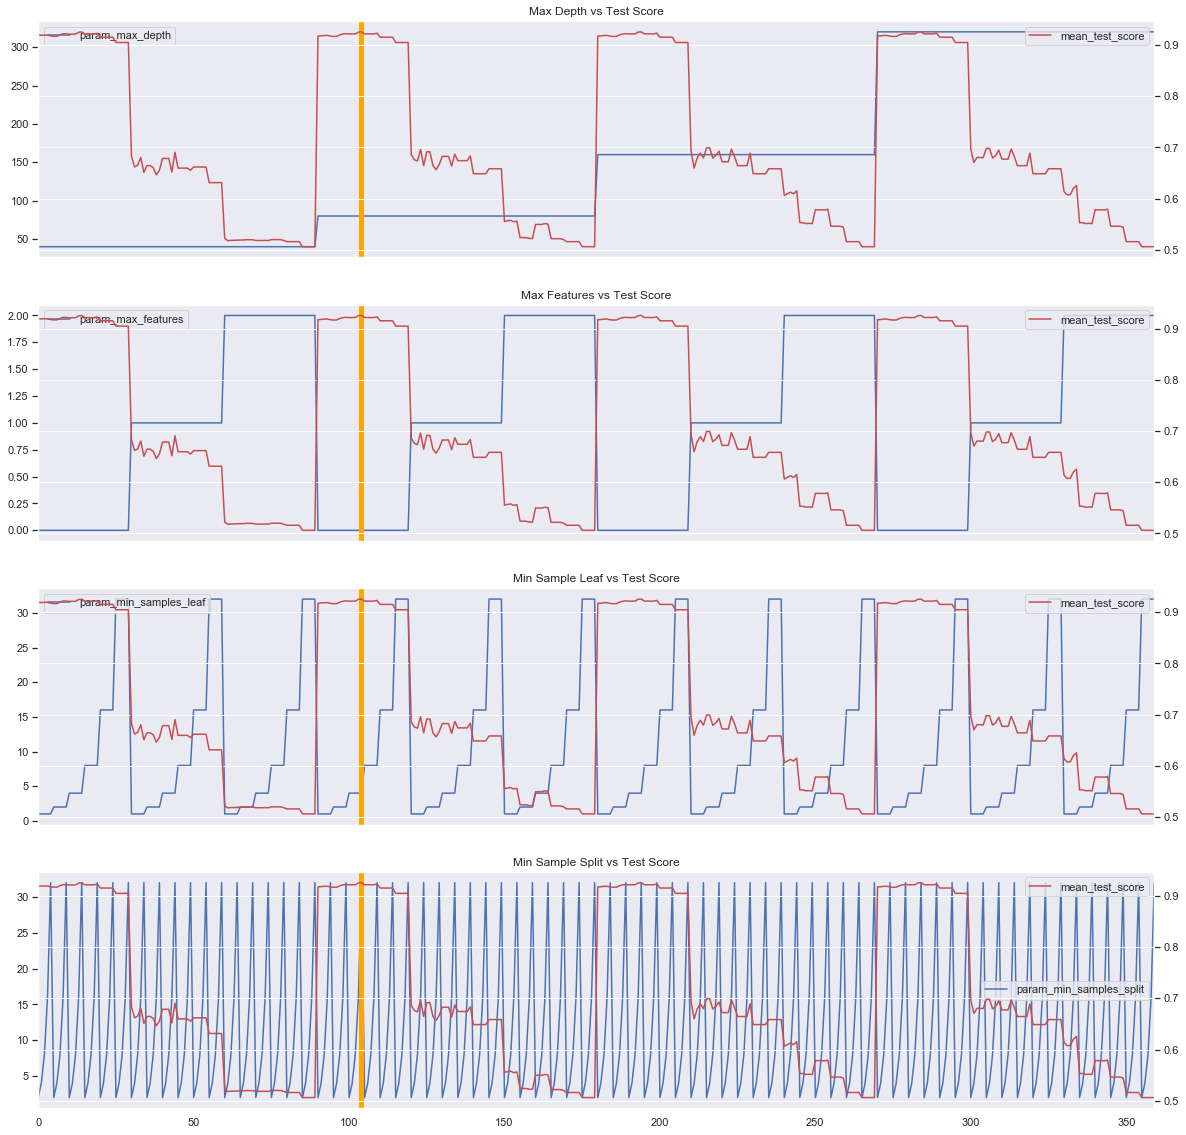

In [142]:
f, a = plt.subplots(4, 1, figsize=(20, 20))

ax = results_df["param_max_depth"].plot(ax=a[0], legend=True)
results_df["mean_test_score"].plot(ax=ax.twinx(), legend=True, color='r')
ax.axvline(gscv.best_index_, 0, results_df["param_max_depth"].max(), c='orange', linewidth=5)
ax.set_title("Max Depth vs Test Score")
ax.grid(False)


ax = results_df["param_max_features"].plot(ax=a[1], legend=True)
results_df["mean_test_score"].plot(ax=ax.twinx(), legend=True, color='r')
ax.axvline(gscv.best_index_, 0, results_df["param_max_features"].max(), c='orange', linewidth=5)
ax.set_title("Max Features vs Test Score")
ax.grid(False)

ax = results_df["param_min_samples_leaf"].plot(ax=a[2], legend=True)
results_df["mean_test_score"].plot(ax=ax.twinx(), legend=True, color='r')
ax.axvline(gscv.best_index_, 0, results_df["param_min_samples_leaf"].max(), c='orange', linewidth=5)
ax.set_title("Min Sample Leaf vs Test Score")
ax.grid(False)


ax = results_df["param_min_samples_split"].plot(ax=a[3], legend=True)
results_df["mean_test_score"].plot(ax=ax.twinx(), legend=True, color='r')
ax.axvline(gscv.best_index_, 0, results_df["param_min_samples_split"].max(), c='orange', linewidth=5)
ax.set_title("Min Sample Split vs Test Score")
ax.grid(False)


# Grid Search 2

In [143]:
gscv.best_params_

{'max_depth': 80,
 'max_features': None,
 'min_samples_leaf': 4,
 'min_samples_split': 32}

In [153]:
from sklearn.model_selection import GridSearchCV

dt2 = DecisionTreeClassifier(random_state = RSTATE, max_depth = None, max_features = None)
parameters = { 'min_samples_split': [26, 28, 30, 32, 34, 36, 38, 40, 50],  'min_samples_leaf': [3, 4, 5, 6, 7]}
gscv2 = GridSearchCV(dt2, parameters, cv=5, scoring='accuracy', verbose = 1, refit = True, n_jobs = N_JOBS, return_train_score = True)
gscv2.fit(X_train, y_train)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  8.3min
[Parallel(n_jobs=4)]: Done 225 out of 225 | elapsed:  9.6min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=1,
                                              splitter='best'),
             iid='warn', n_jobs=4,
             param_grid={'min_samples_leaf': [3, 4, 5, 6, 7],
                         'min_samples_split': [26, 28, 30, 32, 34, 36, 38, 40,
 

In [154]:
results_df2 = pd.DataFrame(gscv2.cv_results_)
results_df2.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,16.671052,4.410932,0.595233,0.158819,3,26,"{'min_samples_leaf': 3, 'min_samples_split': 26}",0.931135,0.924938,0.923363,...,0.924351,0.004424,38,0.958669,0.957038,0.956700,0.959374,0.954029,0.957162,0.001855
1,8.141967,0.389008,0.286756,0.062153,3,28,"{'min_samples_leaf': 3, 'min_samples_split': 28}",0.930460,0.924263,0.924263,...,0.924621,0.003853,33,0.957318,0.955519,0.955800,0.958868,0.953100,0.956121,0.001927
2,7.735604,0.407369,0.279373,0.042575,3,30,"{'min_samples_leaf': 3, 'min_samples_split': 30}",0.930910,0.924938,0.923813,...,0.924846,0.003638,29,0.956502,0.955378,0.954562,0.958165,0.951637,0.955249,0.002173
3,7.916434,0.077027,0.235942,0.025309,3,32,"{'min_samples_leaf': 3, 'min_samples_split': 32}",0.930348,0.924826,0.924263,...,0.924576,0.003713,34,0.955320,0.954759,0.953746,0.957489,0.950259,0.954315,0.002369
4,7.592773,0.099127,0.278686,0.055671,3,34,"{'min_samples_leaf': 3, 'min_samples_split': 34}",0.929673,0.924826,0.924826,...,0.924374,0.003818,37,0.954589,0.953634,0.952930,0.956842,0.949133,0.953426,0.002519


In [155]:
gscv2.best_score_

0.9263319003353665

In [156]:
gscv2.best_index_

20

In [157]:
gscv2.best_params_

{'min_samples_leaf': 5, 'min_samples_split': 30}

## Looks like our results are still the same as before with min sample leaf at 4 and min smaple split at 32

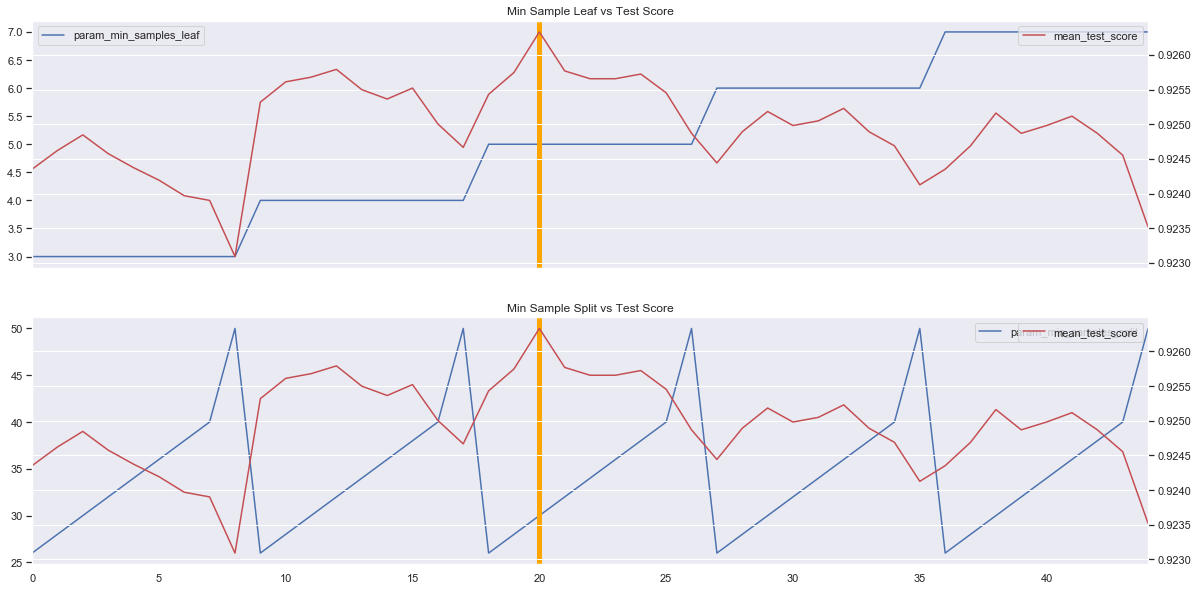

In [158]:
f, a = plt.subplots(2, 1, figsize=(20, 10))

ax = results_df2["param_min_samples_leaf"].plot(ax=a[0], legend=True)
results_df2["mean_test_score"].plot(ax=ax.twinx(), legend=True, color='r')
ax.axvline(gscv2.best_index_, 0, results_df2["param_min_samples_leaf"].max(), c='orange', linewidth=5)
ax.set_title("Min Sample Leaf vs Test Score")
ax.grid(False)


ax = results_df2["param_min_samples_split"].plot(ax=a[1], legend=True)
results_df2["mean_test_score"].plot(ax=ax.twinx(), legend=True, color='r')
ax.axvline(gscv2.best_index_, 0, results_df2["param_min_samples_split"].max(), c='orange', linewidth=5)
ax.set_title("Min Sample Split vs Test Score")
ax.grid(False)


## Let's compare our model accuracy against our test datset

In [159]:
gscv2.best_params_

{'min_samples_leaf': 5, 'min_samples_split': 30}

### Best Model from our Original Grid Search

Model Score: 0.9350438892640108

ROC/AUC Score: 0.934955370085867
              precision    recall  f1-score   support

        Loss       0.92      0.95      0.94      7453
         Win       0.95      0.92      0.93      7357

    accuracy                           0.94     14810
   macro avg       0.94      0.93      0.94     14810
weighted avg       0.94      0.94      0.94     14810

      Loss   Win
Loss  7070   383
Win    579  6778


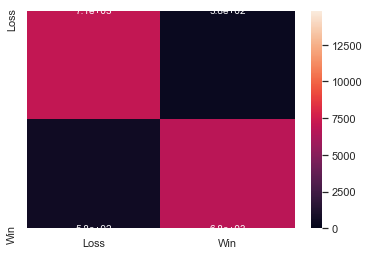

In [162]:
mw = ModelWrapper(gscv.best_estimator_,
                description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test)
y_predict_dt = mw.predict()
mw.analyze()

## Model from our 2nd Grid search

Looks like there is a slight improvement in accuracy compared to our first grid search

Although recall for Losses dropped by a percent, our precision actually increased by 1% - meaning that we are slightly worse at identifying losses but when we do, it tends to be more accurate

Win precision also decreased by 1% but our recall for Wins increased by 1% - meaning we are better at identifying wins in our predictions, however, out of these wins there are more false positives

Model Score: 0.9353814989871708

ROC/AUC Score: 0.9353240708968446
              precision    recall  f1-score   support

        Loss       0.93      0.94      0.94      7453
         Win       0.94      0.93      0.93      7357

    accuracy                           0.94     14810
   macro avg       0.94      0.94      0.94     14810
weighted avg       0.94      0.94      0.94     14810

      Loss   Win
Loss  7037   416
Win    541  6816


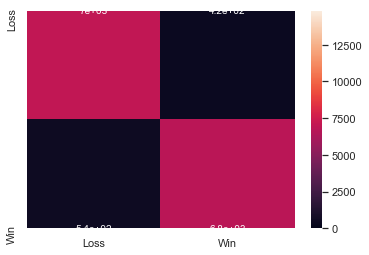

In [166]:
mw2 = ModelWrapper(gscv2.best_estimator_,
                description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test)
y_predict_dt2 = mw2.predict()
mw2.analyze()

## Saving off our model in case we need it later

In [167]:
mw2.save()

Saving report: ../reports/summary.csv
